In [70]:
import random
import time
import math
from matplotlib import pyplot as plt
# importing in alphabetical order? never heard of it...

random.seed(time.time())

# a class to simulate a deck of cards
# the deck contains "card" object with a suit and value attribute

# deck method to create a deck of cards
# We do not assume 52 cards rather, we focus on utilities like shuffling and drawing from the deck
# for now, forgo optimization and just use a list to store the cards
# constructor makes the card_list attribute, but does not fill
class Deck:
    def __init__(self):
        class Card:
            def __init__(self, data):
                self.data = data
                self.id = Card.id
                Card.id += 1

            def __str__(self):
                return f"{self.data}"
        Card.id = 0
        self.Card = Card
        self.card_list = []
        self.card_map = {}

    # store new cards in the deck. The passed data is wrapped in a card object, which generates an id for it
    def push(self, card_data):
        self.card_list.append(self.Card(card_data))

    # method to draw a card from the deck
    # this is good for dealing and stuff, but will screw up the entropy calculation -- a bunny trail anyway
    def pop(self, ):
        if len(self.card_list) == 0:
            raise ValueError("Deck is empty")
        return self.card_list.pop()


    # method to return a snapshot of where every card is in the deck
    # just iterates through and returns a list of card id's
    def get_order(self):
        return [card.id for card in self.card_list]

    # method to restore the deck to a previous order
    # thought this might be faster than making a new deck, but performance didn't end up being an issue
    def restore_order(self, order):
        # iterate through all cards and build a map of card_id to card
        card_map = {}
        for card in self.card_list:
            card_map[card.id] = card
        # iterate through the order list and build a new deck

        new_list = []
        for card_id in order:
            new_list.append(card_map[card_id])
        self.card_list = new_list

    # note: may not be correct if cards have been popped
    # based on the following:
    #    https://stats.stackexchange.com/questions/78591/correlation-between-two-decks-of-cards/79552#79552
    def calculate_shannon_entropy(self):

        # deltas calcultaed by card position vs other cards (order not really important
        # iterate through the deck and build a map of card_id to position
        deltas = []
        for i in range(len(self.card_list)):
            next = i +1
            if next == len(self.card_list):
                next = 0

            delta = self.card_list[next].id - self.card_list[i].id
            if delta < 0:
                delta += len(self.card_list)
            deltas.append(delta)

        # generate histogram of deltas ( trying to find relative frequency of each delta)
        hist = {}
        for delta in deltas:
            if delta in hist:
                hist[delta] += 1
            else:
                hist[delta] = 1

        # calculate entropy **handwaving woo woo, i just copy & pasted this math**
        entropy = 0
        for delta in hist:
            p = hist[delta] / len(deltas)
            entropy += -1 * p * math.log(p)

        return entropy

    def calculate_relative_entropy(self, reference_order):
        # calculate detlas based the difference between the reference order and the current order
        # for each card, want to find where it was in the reference order, then find where it is in the current order
        # then take the difference
        # this will give us the number of positions the card has moved
        # use a map to make this easier
        current_order = self.get_order()
        card_map = {}
        for i in range(len(current_order)):
            card_map[current_order[i]] = i

        deltas = []
        for i in range(len(reference_order)):
            card = reference_order[i]
            current_position = card_map[card]
            delta = current_position - i
            deltas.append(delta)

        # generate histogram of deltas ( trying to find relative frequency of each delta)
        hist = {}
        for delta in deltas:
            if delta in hist:
                hist[delta] += 1
            else:
                hist[delta] = 1

        # calculate entropy **handwaving woo woo, i just copy & pasted this math**
        entropy = 0
        for delta in hist:
            p = hist[delta] / len(deltas)
            entropy += -1 * p * math.log(p)

        return entropy


    # shuffling algorithm is to split the deck in half, then merge the two halves
    # merging is done randomly by choosing a card from each half
    # the card is then appended to a new list
    # this continues until one of the halves is empty, at which point the remainder of the other half is
    # appended to the new list
    def shuffle(self, iters = 1, stdev = 1/30):
        for _ in range(iters):
            # let's simulate the fact that the split is often imperfect
            # let's say that the split point is a gaussian centered at the deck midpoint,
            # and with a standard deviation at 1/30 the length of the deck
            mid = len(self.card_list) // 2
            split_point = int(random.gauss(mid, len(self.card_list) * stdev))

            top = self.card_list[:split_point]
            bottom = self.card_list[split_point:]
            new_deck = []
            while len(top) > 0 and len(bottom) > 0:
                if random.random() > 0.5:
                    new_deck.append(top.pop(0))
                else:
                    new_deck.append(bottom.pop(0))
            self.card_list = new_deck + top + bottom


    # a method to split the deck into an arbitrary point, then swaps the order of the two portions
    # the point at which the deck is split will be random unless defined by the user
    # cut ratio must be a float between 0 and 1
    def cut(self, ratio = None):
        if ratio == None:
            ratio = random.random()
        if not ratio > 0 and ratio < 1:
            raise ValueError("Cut ratio must be between 0 and 1")

        deck_len = len(self.card_list)
        cut_point = int(deck_len * ratio)
        front = self.card_list[:cut_point]
        back = self.card_list[cut_point:]
        self.card_list = back + front

    # so i can print nicely, because I debug like a heathen apparently
    def __str__(self):
        retstr = "[\n"
        for card in self.card_list:
            retstr += f"\t{card}\n"
        retstr += "]"
        return retstr

    def copy(self):
        new_deck = Deck()
        new_deck.card_list = self.card_list.copy()
        return new_deck

    def deal(self, num_players, hand_size):
        hands = []
        for _ in range(num_players):
            hands.append([])
        for _ in range(hand_size):
            for p in range(num_players):
                hands[p].append(self.pop().data)
        return hands


In [47]:
## llama functions
# function to generate a deck of llama cards
# didn't know how many cards were in a llama deck when I started this, so its a parameter
def gen_llama_deck(duplicates = 1):
    llama_deck = Deck()
    # new deck object is empty
    # don't need suites or anything, so we'll just push in numbers 0-6
    for _ in range(duplicates):
        for j in range(7):
            llama_deck.push(j)

    return llama_deck


# need a function to check if a hand is "llamable"
# see readme for better description, but it basically needs to make a continuous sequence that can:
#  - wrap around
#  - have duplicates
# strategy here is to sort the hand, then calculate the deltas between each card then see if there's any gaps
# use special case to handle wrap-araound and ignore deltas of 0 to handle duplicates
def check_llamable(hand):
    # don't judge my lazy ass-erts
    assert len(hand) > 0, f"Hand must have at least one card -- {hand}"
    assert max(hand) <= 6, f"Hand cannot contain cards greater than 6 -- {hand}"
    assert min(hand) >= 0, f"Hand cannot contain cards less than 0 -- {hand}"

    hand.sort()
    deltas = []
    for i in range(len(hand) - 1):
        deltas.append(hand[i+1] - hand[i])

    # wrapparound case
    deltas.append(hand[0] - hand[-1] + 7)

    # check how many deltas are > 1
    # if there are 2 or more, the hand is not llamable
    non_1_deltas = [d for d in deltas if d > 1]
    if len(non_1_deltas) > 1:
        return False
    return True

# UNIT TESTING CAUSE I'M A PROFESSIONAL
# and also cause i screwed this up way too much to not test the crap out of it, else my results are meaningless
#     ~~~~ they're meaningless anyway, you say??? ~~~~~
test_hands = [
    ([0, 1, 2, 3, 4, 5, 6], True),
    ([1, 2, 3, 4, 5, 6], True),
    ([1], True),
    ([1,1,1,1,1], True),
    ([1,2], True),
    ([0,6], True),
    ([6,4,5], True),
    ([5,5,2,4,3], True),
    ([5,6,0,1,2], True),
    ([5,6,1,2], False),
    ([1,3,5], False),
    ([1,1,3,3,5,5,5], False),
    ([2,4,6], False),
    ([2,2,4,4,6,6], False),
]

# woo woo, testing
class TestFailure(Exception):
    pass

failure = False  # my son?
for hand,result in test_hands:
    try:

        if not check_llamable(hand) == result:
            raise TestFailure(f"Test failed for hand {hand}, expected {result}")
    except Exception as e:
        print(e)
        failure = True
        if not type(e) == TestFailure:
            print(f" exception on while checking{hand}")
            raise e

# colors make me happy
if not failure:
    print("\033[92m"+"All tests passed"+"\033[0m")
else:
    print("\033[91m"+"Some tests failed"+"\033[0m")


All tests passed


In [108]:
# code ended up being performant enough that I decided to run the sim with some different parameters
# this cell does all the sim, the next does the plotting
N = 100000
data = {}
MIN_PLAYERS = 2
MAX_PLAYERS = 8
MIN_SHUFFLE_ITERS = 1
MAX_SHUFFLE_ITERS = 10

HAND_SIZE = 6
DUPLICATE_DEPTH=8
data = {}
for p in range(MIN_PLAYERS, MAX_PLAYERS + 1):
    data[p] = {}
    for i in range(MIN_SHUFFLE_ITERS, MAX_SHUFFLE_ITERS + 1):
        data[p][i] = {
            "total_hands": 0,
            "llamable_hands": 0,
            "total_deals": 0,
            "any_llamable": 0
        }
start_time = time.time()
last_n = 0
last_t = start_time
for n in range(N):
    deck = gen_llama_deck(DUPLICATE_DEPTH)
    deck.shuffle(MIN_SHUFFLE_ITERS)
    for i in range(MIN_SHUFFLE_ITERS,MAX_SHUFFLE_ITERS + 1):
        for p in range(MIN_PLAYERS, MAX_PLAYERS + 1):
            deal_deck = deck.copy()
            hands = deal_deck.deal(p, HAND_SIZE)
            data[p][i]['total_hands'] += len(hands)
            data[p][i]['total_deals'] += 1
            any_llamable_this_deal = 0
            for hand in hands:
                if check_llamable(hand):
                    data[p][i]['llamable_hands'] += 1
                    any_llamable_this_deal = 1

            data[p][i]['any_llamable'] += any_llamable_this_deal

        deck.shuffle()

    # status update
    if n % (N/1000) == 0:
        now = time.time()
        elapsed_time = now - start_time
        elapsed_iters = n - last_n
        percent_done = n/N
        iters_per_second = elapsed_iters / (now-last_t)
        # estimate time remaining
        remaining_iters = N - n
        if iters_per_second == 0:
            remaining_seconds = 0
        else:
            remaining_seconds = remaining_iters / iters_per_second

        print(f"{n / N * 100:.1f}% -- {elapsed_time:.2f} s elapsed -- {iters_per_second:.2f} ips -- estimate {remaining_seconds:.2f} s remaining", end = "\r")

        last_n = n
        last_t = now
print()
print(f"100% -- done after {time.time() - start_time:.2f} seconds -- {N / (time.time() - start_time)} ips")
# calculate full ratios
for p in range(MIN_PLAYERS, MAX_PLAYERS + 1):
    for i in range(MIN_SHUFFLE_ITERS, MAX_SHUFFLE_ITERS + 1):
        data[p][i]['llamable_ratio'] = data[p][i]['llamable_hands'] / data[p][i]['total_hands']
        data[p][i]['any_llamable_ratio'] = data[p][i]['any_llamable'] / data[p][i]['total_deals']


99.9% -- 142.89 s elapsed -- 711.93 ips -- estimate 0.14 s remainingg
100% -- done after 143.03 seconds -- 699.1594815178385 ips


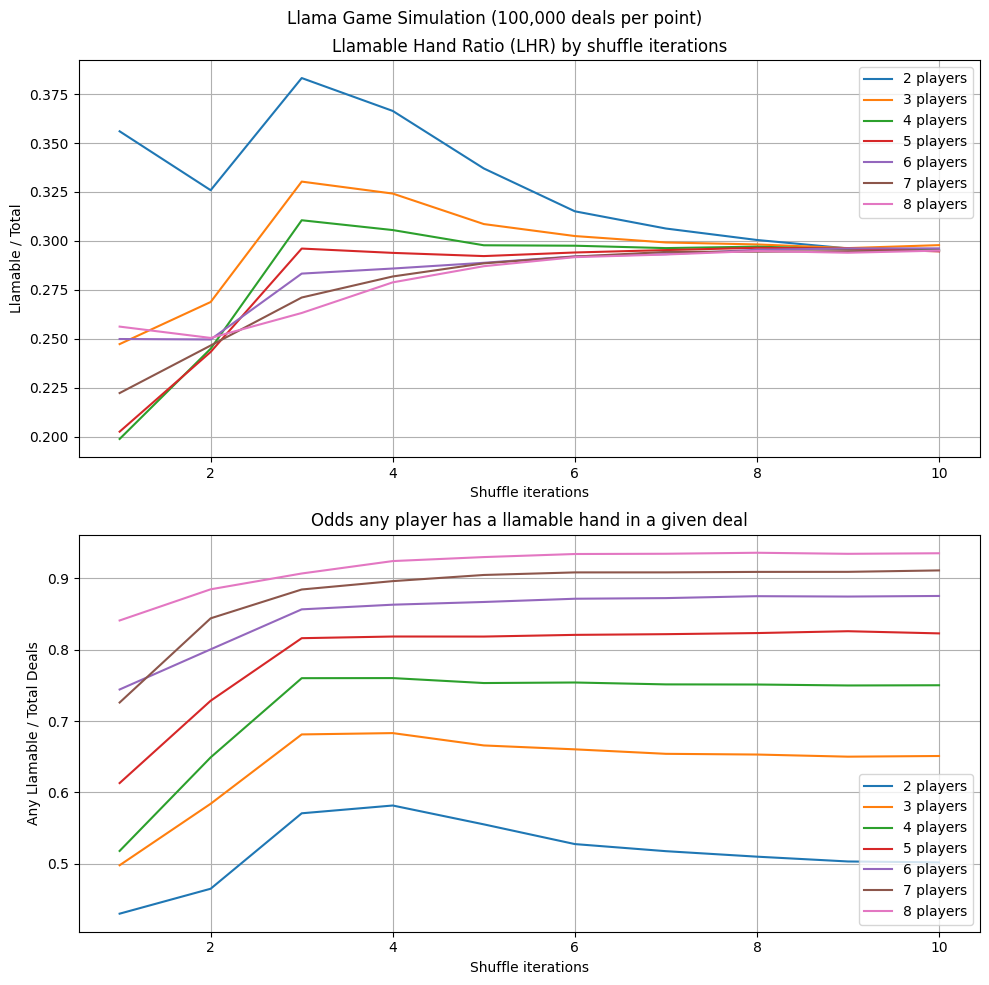

In [109]:
# plot the results
f, ax = plt.subplots(2, 1, figsize = (10, 10))
for playercount in data:
    llamable_ratios = [data[playercount][i]["llamable_ratio"] for i in range(MIN_SHUFFLE_ITERS, MAX_SHUFFLE_ITERS+1)]
    any_llamable_ratios = [data[playercount][i]["any_llamable_ratio"] for i in range(MIN_SHUFFLE_ITERS, MAX_SHUFFLE_ITERS+1)]
    ax[0].plot(range(MIN_SHUFFLE_ITERS, MAX_SHUFFLE_ITERS+1), llamable_ratios, label = f"{playercount} players")
    ax[1].plot(range(MIN_SHUFFLE_ITERS, MAX_SHUFFLE_ITERS+1), any_llamable_ratios, label = f"{playercount} players")

for a in ax:
    a.legend()
    a.grid()

# title axes and plot
ax[0].set_title("Llamable Hand Ratio (LHR) by shuffle iterations")
ax[0].set_xlabel("Shuffle iterations")
ax[0].set_ylabel("Llamable / Total")
ax[1].set_title("Odds any player has a llamable hand in a given deal")
ax[1].set_xlabel("Shuffle iterations")
ax[1].set_ylabel("Any Llamable / Total Deals")

# space the plots out
f.tight_layout()

# title for the whole figure
f.suptitle(f"Llama Game Simulation ({N:,} deals per point)")
# git the super title more space above
f.subplots_adjust(top = 0.93)


/tmp/ipykernel_4399/3746287100.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


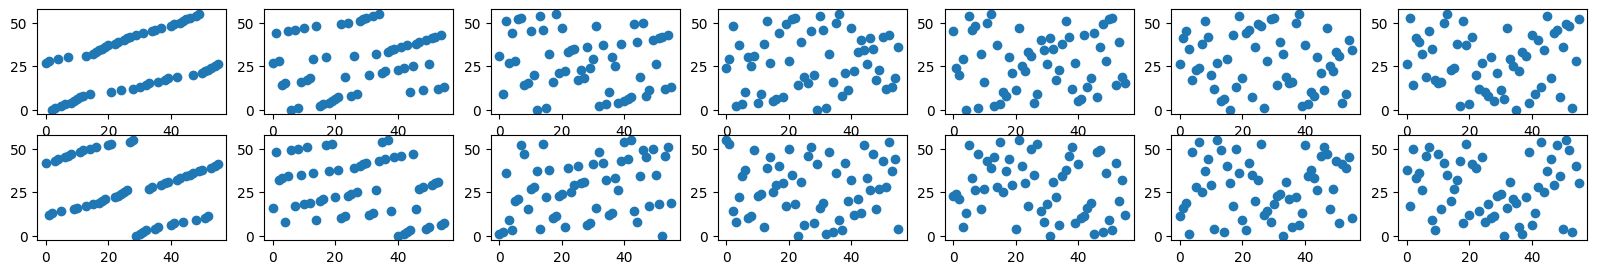

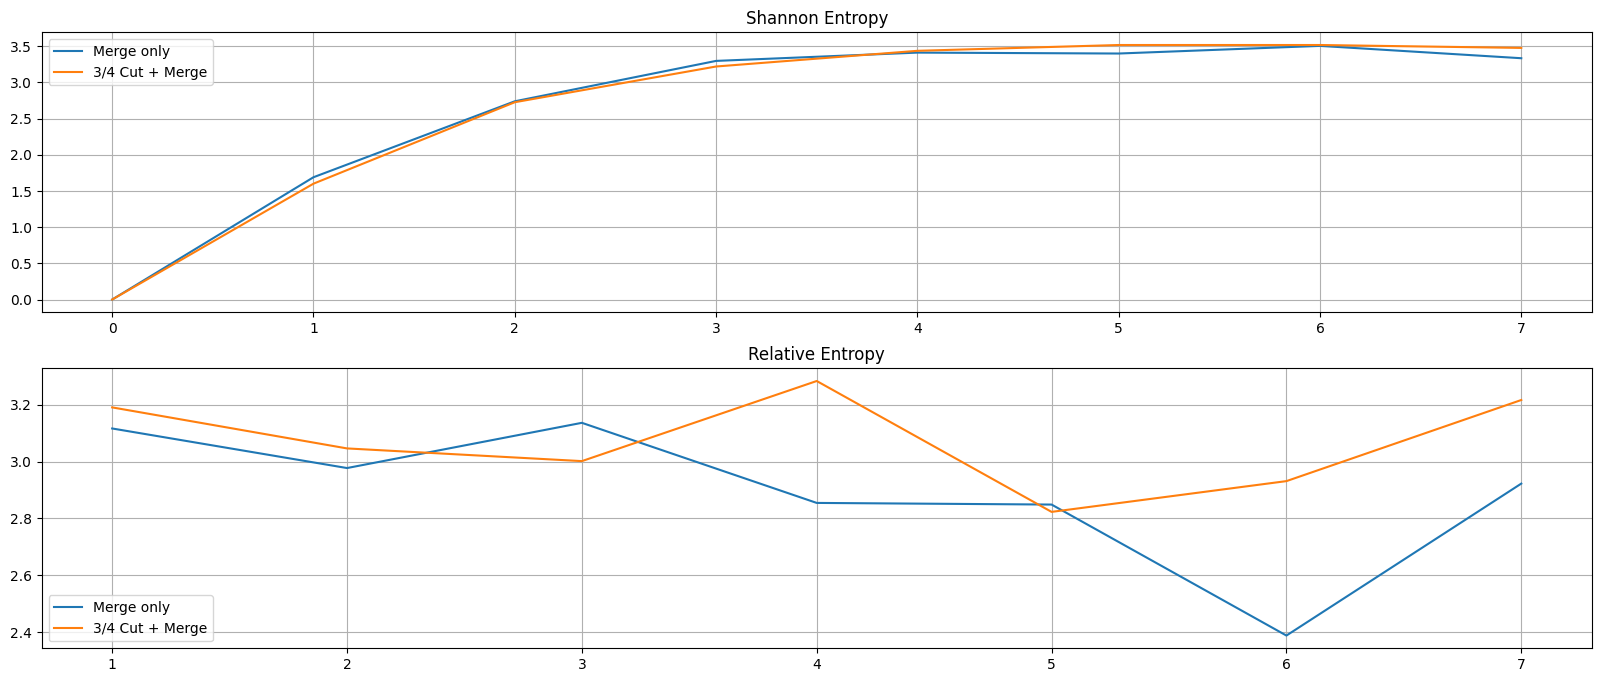

In [100]:
# ok so this is totally out of scope for llama game, but I decided to test my shuffling method and also to test
# a shuffling strategy I've used for a while IRL

# gonna move this to the end of the file, but it's kinda cool so I'm leaving it in

S = 1/30

ld =  gen_llama_deck(8)
shuffle_iters = 7

f, ax = plt.subplots(2, (shuffle_iters), figsize = (20, 3))

def plot_order(ax, order):
    # scatterplot
    ax.plot(range(len(order)), order, 'o')

initial_order = ld.get_order()
last_order = initial_order
re_1 = [ld.calculate_relative_entropy(initial_order)]
e_1 = [ld.calculate_shannon_entropy()]
for i in range(shuffle_iters):
    ld.shuffle(stdev=S)
    e_1.append(ld.calculate_shannon_entropy())
    re_1.append(ld.calculate_relative_entropy(last_order))
    plot_order(ax[0][i], ld.get_order())
    last_order = ld.get_order()

ld.restore_order(initial_order)
last_order = initial_order
re_2 = [ld.calculate_relative_entropy(initial_order)]
e_2 = [ld.calculate_shannon_entropy()]
for i in range(shuffle_iters):
    ld.cut(0.75)
    ld.shuffle(stdev=S)
    e_2.append(ld.calculate_shannon_entropy())
    re_2.append(ld.calculate_relative_entropy(last_order))
    plot_order(ax[1][i], ld.get_order())
    last_order = ld.get_order()

f.show()

f, ax = plt.subplots(2, 1, figsize = (20, 8))

ax[0].plot(range(shuffle_iters + 1), e_1, label = "Merge only")
ax[0].plot(range(shuffle_iters + 1), e_2, label = "3/4 Cut + Merge")
ax[0].set_title("Shannon Entropy")

ax[1].plot(range(1,shuffle_iters + 1), re_1[1:], label = "Merge only")
ax[1].plot(range(1,shuffle_iters + 1), re_2[1:], label = "3/4 Cut + Merge")
ax[1].set_title("Relative Entropy")

for a in ax:
    a.legend()
    a.grid()

# run this enough and you'll see that my cut + merge strategy is not actually any better for the total entropy
# it might be better for the cards at the very edges, but is neglible to the total shannon entropy, and you
# can solve the issue of the edge cards staying at the edges by just cutting at the end of shuffling


In [111]:
MAX_SHUFFLES = 10
N = 100000
S = 1/30
normal_shuffle_entropies = [0 for _ in range(MAX_SHUFFLES)]
split_shuffle_entropies = [0 for _ in range(MAX_SHUFFLES)]
for n in range(N):
    ld = gen_llama_deck(8)
    ld2 = ld.copy()
    for i in range(MAX_SHUFFLES):
        ld.shuffle(stdev=S)

        ld2.cut(0.75)
        ld2.shuffle(stdev=S)

        normal_shuffle_entropies[i] += ld.calculate_shannon_entropy()
        split_shuffle_entropies[i] += ld2.calculate_shannon_entropy()

avg_normal = [x / N for x in normal_shuffle_entropies]
avg_split = [x / N for x in split_shuffle_entropies]


/tmp/ipykernel_4399/4229142497.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


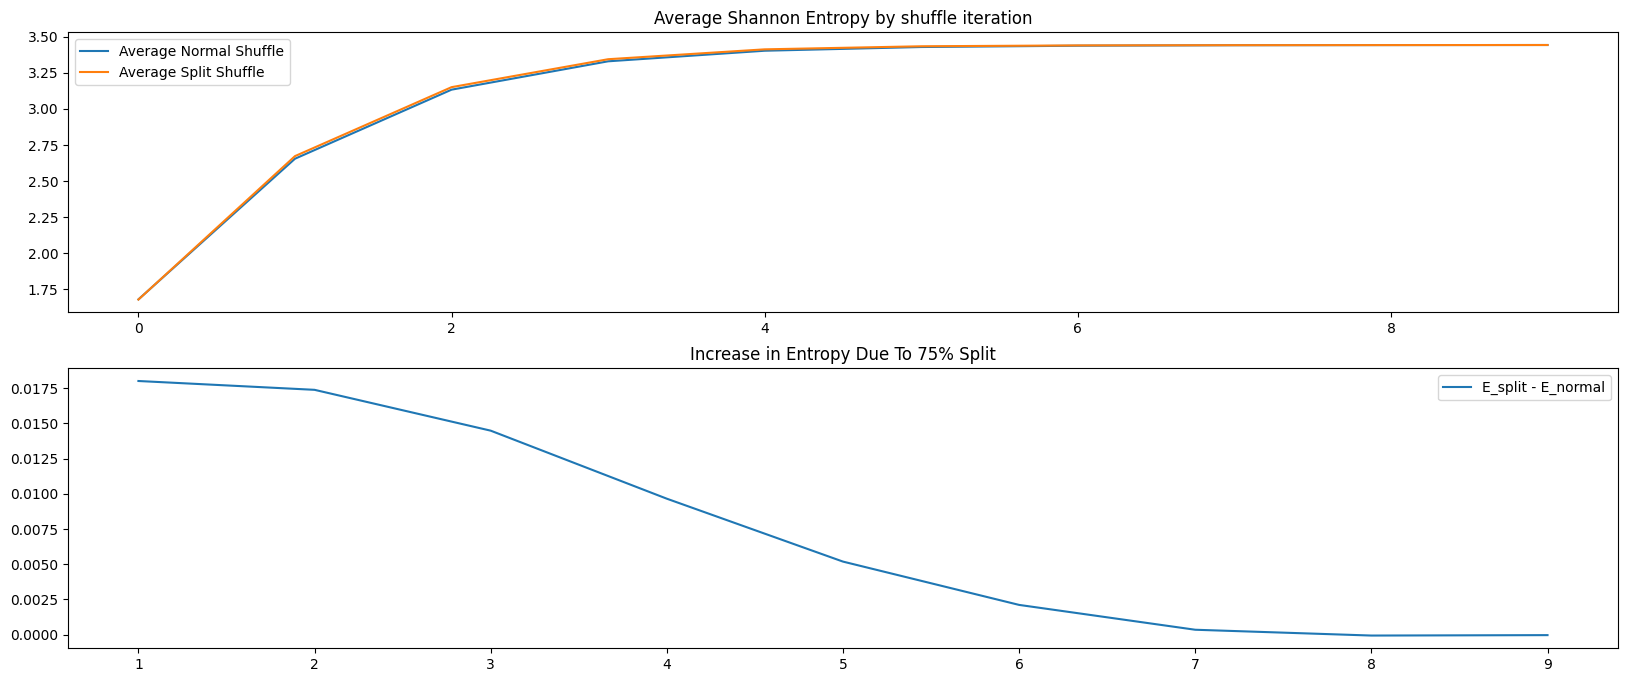

In [119]:

f, ax = plt.subplots(2, 1, figsize = (20, 8))
ax[0].plot(range(MAX_SHUFFLES), avg_normal, label = "Average Normal Shuffle")
ax[0].plot(range(MAX_SHUFFLES), avg_split, label = "Average Split Shuffle")

ax[0].legend()

ax[0].set_title("Average Shannon Entropy by shuffle iteration")

ax[1].plot(range(1, MAX_SHUFFLES), [avg_split[i] - avg_normal[i] for i in range(1,MAX_SHUFFLES)], label = "E_split - E_normal")
ax[1].legend()
ax[1].set_title("Increase in Entropy Due To 75% Split")

f.show()
